In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from xml.etree import ElementTree

In [2]:
# Assuming a function to parse XML annotations and return dimensions and locations
def parse_annotations(annotation_path):
    annotations = []
    for filename in os.listdir(annotation_path):
        if not filename.endswith('.xml'): continue
        full_path = os.path.join(annotation_path, filename)
        tree = ElementTree.parse(full_path)
        root = tree.getroot()
        for object in root.findall('object'):
            for box in object.findall('bndbox'):
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                annotations.append([xmin, ymin, xmax, ymax])
    return annotations

annotations = parse_annotations('../images')

# What are the typical sizes/dimensions of these bounding boxes?

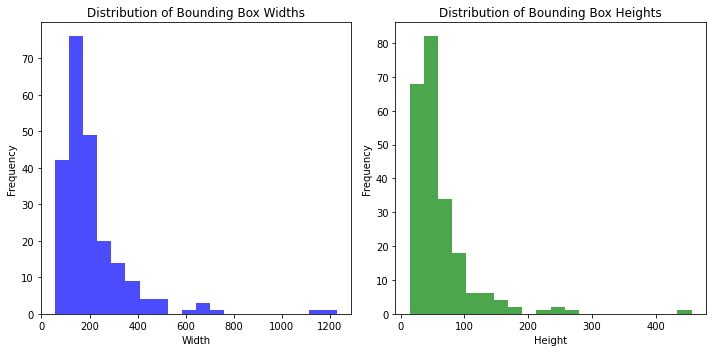

In [16]:
# Calculate widths and heights of bounding boxes
widths = [xmax - xmin for xmin, ymin, xmax, ymax in annotations]
heights = [ymax - ymin for xmin, ymin, xmax, ymax in annotations]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As we see above, the most likely height is around 70-80, and the most likely width is about 170-180. 
#### How will this influence the ALPR system design:

It would make sense to attempt to normalize the aspect ratio of the input images or regions to account for the wide variety of ranges for both width and height. It is also useful to know that since there are many different size boxes, utilizing a training that deals with augmented scaling and cropping will most likely help the model learn on any image size so it doesn't get too used to a single size and cannot work for odd aspect ratios. 

# What are the typical locations of these boxes relative to the image space?

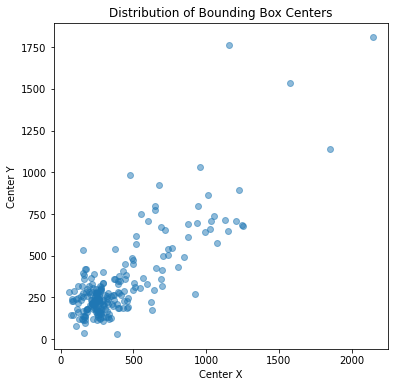

In [4]:
# Calculate bounding box center points
centers = [(xmin + (xmax-xmin)/2, ymin + (ymax-ymin)/2) for xmin, ymin, xmax, ymax in annotations]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter([c[0] for c in centers], [c[1] for c in centers], alpha=0.5)
plt.title('Distribution of Bounding Box Centers')
plt.xlabel('Center X')
plt.ylabel('Center Y')
plt.show()

As we can see for most license plates we find they are in the lower left side of the image, which makes sense as license plates tend to be near the bottom of the car. It is good to note that with this we can still see some license plates are in the upper right hand corner of the images, meaning they are in abnormal places and should be noted for proper handling in the image.

#### How will this influence the ALPR system design:

Knowing the location they tend to be in the image we can help our model by telling it to look there first, before moving on to the rest of the image. This could vastly speed up the efficeincy of our model as it doesn't need to look through the entire image to find the license plate (still may need to, but it will be less likely to). We also need to ensure that while training the model we don't accidentaly make it unable to detect license plates in other areas of the image if it is not in the lower left side. 

# Aspect Ratios of the bounding boxes

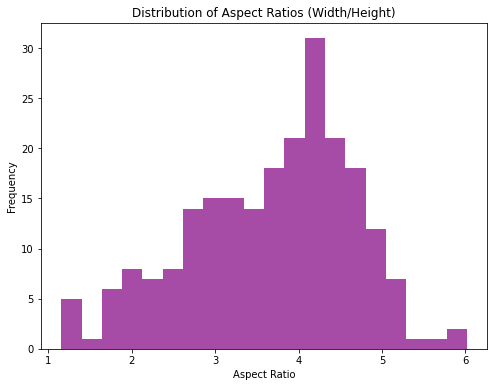

In [17]:
# Calculate aspect ratios of the bounding boxes
aspect_ratios = [float(width) / height if height > 0 else 0 for width, height in zip(widths, heights)]

# Plot the distribution of aspect ratios
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Aspect Ratios (Width/Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

#### How will this influence the ALPR system design:

A major thing that can be influenced here is in preprocessing. We may need to ensure that images coming in are normalized or atleast flagged taht they have highly unusual aspect ratios. When designing the features we may want to ensure that the features are sensitive to aspect ratios of the object. 

# Colors held within each image for license plates

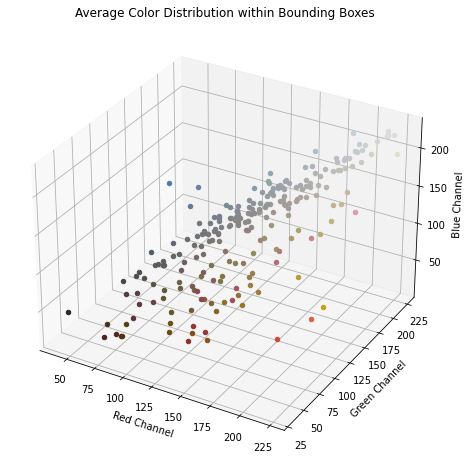

In [24]:
# Load annotations from XML files and create a mapping to image file names
def load_annotations(annotation_folder_path):
    image_annotations_mapping = {}
    for filename in os.listdir(annotation_folder_path):
        if not filename.endswith('.xml'): continue
        full_path = os.path.join(annotation_folder_path, filename)
        tree = ElementTree.parse(full_path)
        root = tree.getroot()
        image_file = root.find('filename').text
        boxes = []
        for object in root.findall('object'):
            for box in object.findall('bndbox'):
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                boxes.append((xmin, ymin, xmax, ymax))
        image_annotations_mapping[image_file] = boxes
    return image_annotations_mapping

# Path to your dataset folder
annotation_folder_path = '../images'
image_folder_path = '../images'

# This will create a dictionary mapping image file names to bounding box annotations
image_annotations_mapping = load_annotations(annotation_folder_path)

# Function to calculate the average color within the bounding boxes
def calculate_average_color(image_path, annotations):
    average_colors = []
    for ann in annotations:
        xmin, ymin, xmax, ymax = ann
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
        cropped_image = image[ymin:ymax, xmin:xmax]
        average_color = np.mean(cropped_image, axis=(0, 1))
        average_colors.append(average_color)
    return average_colors

# Assuming we have a mapping of image file names to their corresponding bounding box annotations
image_folder_path = '../images'
all_average_colors = []
for filename, ann in image_annotations_mapping.items():
    image_path = os.path.join(image_folder_path, filename)
    avg_colors = calculate_average_color(image_path, ann)
    all_average_colors.extend(avg_colors)

# Now, plot the distribution of average colors
# Since color is a 3-dimensional data, we'll plot it in a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for color in all_average_colors:
    ax.scatter(color[0], color[1], color[2], color=color / 255.0)  # Normalize color values

ax.set_xlabel('Red Channel')
ax.set_ylabel('Green Channel')
ax.set_zlabel('Blue Channel')
ax.set_title('Average Color Distribution within Bounding Boxes')
plt.show()

#### How will this influence the ALPR system design:

As we can see in the graph above we find that there is a large array of different colors that come in for the license plates and cars. We may want to grey scale images coming in to avoid any biases towards certain colors, or issues due to certain colors. For determining where the license plate is, this knowledge may also be helpful to try and find certain colors on cars for the model to look for to find the license plate easier, this may not be possible with our data but would be useful if we knew exactly where we were implementing this in the state to check for a specific license plate color for that area.

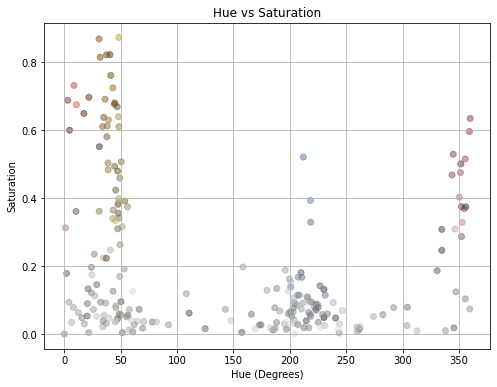

In [26]:
# Convert RGB to HSV and plot Hue and Saturation
import matplotlib.colors as colors

all_average_colors_hsv = colors.rgb_to_hsv(all_average_colors_np / 255.0)

plt.figure(figsize=(8, 6))
plt.scatter(all_average_colors_hsv[:, 0] * 360, all_average_colors_hsv[:, 1], alpha=0.5,
            c=all_average_colors_np / 255)
plt.xlabel('Hue (Degrees)')
plt.ylabel('Saturation')
plt.title('Hue vs Saturation')
plt.grid(True)
plt.show()

#### How will this influence the ALPR system design:

Much like the color graph it may be possible to train the model to search for specific hues or saturations for easier detection of where the license plate is located as the car passes by. We would definitely want to look into color normalization as we have a wide variety of how it is coming in. We may also want to do some noise reduction to help focus in on the license plate instead of the rest of the scene. 